## 로지스틱 회귀

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [5]:
cancer = load_breast_cancer()

scaler = StandardScaler()
data_scaled = scaler.fit_transform(cancer.data)
X_train, X_test, y_train, y_test = train_test_split(data_scaled, cancer.target, test_size=0.3, random_state=0)

In [17]:
from sklearn.metrics import accuracy_score, roc_auc_score

# lbfgs는 penalty로 l2만 가능하므로 liblinear로 변경
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train)
lr_preds = lr_clf.predict(X_test)

print(f'accuracy: {accuracy_score(y_test, lr_preds):.3f}')
print(f'roc_auc: {roc_auc_score(y_test, lr_preds):.3f}')

accuracy: 0.982
roc_auc: 0.979


In [15]:
from sklearn.model_selection import GridSearchCV

params = {
    'penalty':['l2', 'l1'],
    'C':[0.01, 0.1, 1, 5, 10]
}
grid_clf = GridSearchCV(lr_clf, param_grid = params, scoring='accuracy', cv=3)
grid_clf.fit(data_scaled, cancer.target)
print(grid_clf.best_params_, grid_clf.best_score_)

{'C': 0.1, 'penalty': 'l2'} 0.9789102385593614


## 회귀 트리

In [18]:
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

In [21]:
boston = load_boston()
bostonDF = pd.DataFrame(boston.data, columns=boston.feature_names)
bostonDF['PRICE'] = boston.target

X_data = bostonDF.drop(['PRICE'], axis=1)
y_target = bostonDF['PRICE']

rf = RandomForestRegressor(random_state=0, n_estimators=1000)
neg_mse_scores = cross_val_score(rf, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print('5-folds Negative MSE scores:', np.round(neg_mse_scores, 2))
print('5-folds RMSE scores:', np.round(rmse_scores, 2))
print('5-folds mRMSE:', round(avg_rmse, 3))

5-folds Negative MSE scores: [ -7.88 -13.14 -20.57 -46.23 -18.88]
5-folds RMSE scores: [2.81 3.63 4.54 6.8  4.34]
5-folds mRMSE: 4.423


In [20]:
def get_model_cv_prediction(model, X_data, y_target):
    neg_mse_scores = cross_val_score(model, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
    rmse_scores = np.sqrt(-1*neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    print('#####', model.__class__.__name__, '#####')
    print('5-folds mRMSE:', round(avg_rmse, 3))

In [22]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRFRegressor
from lightgbm import LGBMRegressor
import time

start = time.time()

dt_reg = DecisionTreeRegressor(random_state=0, max_depth=4)
rf_reg = RandomForestRegressor(random_state=0, n_estimators=1000)
gb_ref = GradientBoostingRegressor(random_state=0, n_estimators=1000)
xbg_reg = XGBRFRegressor(n_estimators=1000)
lgb_reg = LGBMRegressor(n_estimators=1000)

models = [dt_reg, rf_reg, gb_ref, xbg_reg, lgb_reg]
for model in models:
    get_model_cv_prediction(model, X_data, y_target)
    
print(time.time()-start,'sec')

##### DecisionTreeRegressor #####
5-folds mRMSE: 5.978
##### RandomForestRegressor #####
5-folds mRMSE: 4.423
##### GradientBoostingRegressor #####
5-folds mRMSE: 4.269
##### XGBRFRegressor #####
5-folds mRMSE: 4.537
##### LGBMRegressor #####
5-folds mRMSE: 4.646
35.884602546691895 sec


<AxesSubplot:>

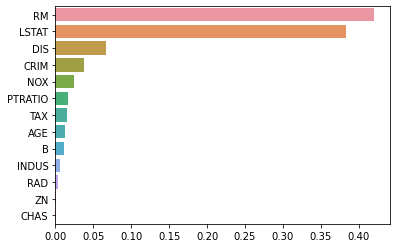

In [23]:
import seaborn as sns
%matplotlib inline

rf_reg = RandomForestRegressor(n_estimators=1000)
rf_reg.fit(X_data, y_target)

feature_series = pd.Series(data=rf_reg.feature_importances_, index=X_data.columns)
feature_series = feature_series.sort_values(ascending=False)
sns.barplot(x=feature_series, y=feature_series.index)

(100, 2)


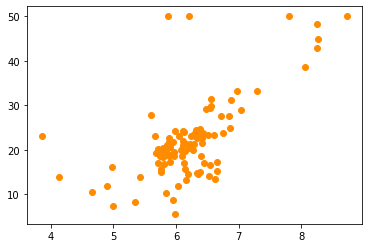

In [28]:
import matplotlib.pyplot as plt

bostonDF_sample = bostonDF[['RM', 'PRICE']]
bostonDF_sample = bostonDF_sample.sample(n=100, random_state=0)
print(bostonDF_sample.shape)

plt.figure()
plt.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c='darkorange')

In [29]:
from sklearn.linear_model import LinearRegression

lr_reg = LinearRegression()
rf_reg2 = DecisionTreeRegressor(max_depth=2)
rf_reg7 = DecisionTreeRegressor(max_depth=7)

X_test = np.arange(4.5, 8.5, 0.04).reshape(-1, 1)

X_feature = bostonDF_sample['RM'].values.reshape(-1, 1)
y_target = bostonDF_sample['PRICE'].values.reshape(-1, 1)

lr_reg.fit(X_feature, y_target)
rf_reg2.fit(X_feature, y_target)
rf_reg7.fit(X_feature, y_target)

pred_lr = lr_reg.predict(X_test)
pred_rf2 = rf_reg2.predict(X_test)
pred_rf7 = rf_reg7.predict(X_test)

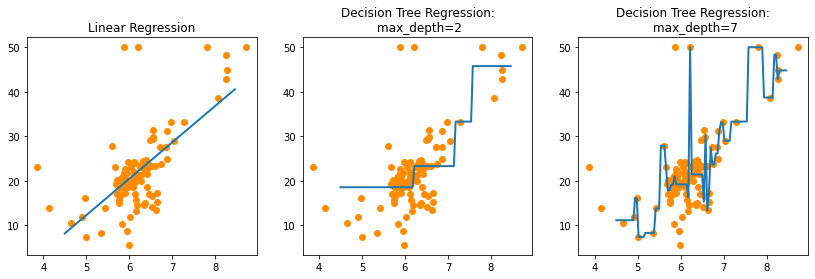

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(14, 4), ncols=3)

ax1.set_title('Linear Regression')
ax1.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c='darkorange')
ax1.plot(X_test, pred_lr, label='linear', linewidth=2)

ax2.set_title('Decision Tree Regression:\n max_depth=2')
ax2.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c='darkorange')
ax2.plot(X_test, pred_rf2, label='max_depth:2', linewidth=2)

ax3.set_title('Decision Tree Regression:\n max_depth=7')
ax3.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c='darkorange')
ax3.plot(X_test, pred_rf7, label='max_depth:7', linewidth=2)